# Epidemiological modelling of spread of COVID-19 in Germany and South Korea

## Import modules

Imports all functions required for executing the cells in the notebook

In [0]:
!pip install mpld3
import mpld3
import io
%matplotlib inline 
import numpy as np
import pandas as pd
import math
from pandas import DataFrame
import seaborn as sb
%matplotlib inline
mpld3.enable_notebook()
import plotly.express as px
from google.colab import files
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import odeint
from scipy.optimize import minimize

## Define models

SEIRD model

Susceptible, Exposed, Infected, Recovered and Dead people being modelled for a country

In [0]:
# static SEIRD model - all parameters remain the same across all time points
def SEIRD(y, t, N, beta, gamma, delta, mu):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Integrating SEIRD model

Integrating the SEIRD model over time period t specified

In [0]:
def SEIRD_integrate(initial, t, params):
    # initial = (S0, E0, I0, R0, D0)
    # params = beta, delta, gamma, mu

    t = list(range(t)) # creates a list of time points with length t
    beta, delta, gamma, mu = params
    result = odeint(SEIRD, initial, t, args=(N, beta, delta, gamma, mu))
    return result

SEIRD Lockdown

Change of equations for the SEIRD model to factor in phase based change in contact rate for a country

In [0]:
def SEIRD_lockdown(y, t, l1, l2, l3, gamma, delta, mu):
    if t < L1:
        beta = l1 * gamma
    elif t < L2:
        beta = l2 * gamma
    else:
        beta = l3 * gamma
    S, E, I, R, D = y
    dSdt = -beta * S * I / N + gamma * I
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Integrating the SEIRD lockdown model

Integrating the SEIRD lockdown model over time period t specified

In [0]:
### SEIRD Lockdown model loss
# Integrate the SEIRD equations over the time grid, t.
def SEIRD_integrate_lockdown(initial, t, params):
    # initial = (S0, E0, I0, R0, D0)
    # params = beta, delta, gamma, mu

    t = list(range(t)) # creates a list of time points with length t
    l1, l2, l3, gamma, delta, mu = params
    result = odeint(SEIRD_lockdown, initial, t, args=(l1, l2, l3, gamma, delta, mu))
    return result

## Functions for saving and plotting

Save Dataframe

Function to save the imported data of countries to data frame

In [0]:
def get_dataframe(result):
    result = pd.DataFrame(result, columns = ['S', 'E', 'I', 'R', 'D'])
    time_points = list(range(len(result)))
    result.insert(0, 'days', time_points, True)
    return result

Calculate model loss for the modelling Germany

Function to calculate squared error loss between predicted and actual data for Germany

In [0]:
# requires there to be a data frame called "germany_actual"
def model_loss_germany(params):
    r = 0 # residual
    for t in range(1, len(germany_actual) + 1):
        r += (SEIRD_integrate(y0, t, params)[t - 1, 2] - germany_actual['active_cases'][t - 1]) ** 2
        r += (SEIRD_integrate(y0, t, params)[t - 1, 3] - germany_actual['total_recovered'][t - 1]) ** 2
        r += (SEIRD_integrate(y0, t, params)[t - 1, 4] - germany_actual['total_deaths'][t - 1]) ** 2
    return math.sqrt(r) 

Calculate model loss for the modelling South Korea

Function to calculate squared error loss between predicted and actual data for South Korea

In [0]:
# requires there to be a data frame called "korea_actual"
def model_loss_sk(params):
    r = 0 # residual
    for t in range(1, len(korea_actual) + 1):
        r += (SEIRD_integrate(y0, t, params)[t - 1, 2] - korea_actual['total_infected'][t - 1]) ** 2
        r += (SEIRD_integrate(y0, t, params)[t - 1, 3] - korea_actual['total recovered'][t - 1]) ** 2
        r += (SEIRD_integrate(y0, t, params)[t - 1, 4] - korea_actual['total_deaths'][t - 1]) ** 2
    return math.sqrt(r) 

Model loss for lockdown SEIRD Germany

Function to calculate squared error loss between predicted and actual data taking into account the three phase model for Germany

In [0]:
# requires there to be a data frame called "germany_actual"
def model_loss_lockdown_germany(params):
    r = 0 # residual
    for t in range(1, len(germany_actual) + 1):
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 2] - germany_actual['active_cases'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 3] - germany_actual['total_recovered'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 4] - germany_actual['total_deaths'][t - 1]) ** 2
    return math.sqrt(r) 

Model loss for lockdown SEIRD South Korea

Function to calculate squared error loss between predicted and actual data taking into account the three phase model for South Korea

In [0]:
# requires there to be a data frame called "korea_actual"
def model_loss_lockdown_sk(params):
    r = 0 # residual
    for t in range(1, len(korea_actual) + 1):
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 2] - korea_actual['total_infected'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 3] - korea_actual['total recovered'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 4] - korea_actual['total_deaths'][t - 1]) ** 2
    return math.sqrt(r) 

Model loss for lockdown SEIRD uploaded data

Function to calculate squared error loss between predicted and actual data taking into account the three phase model for uploaded data

In [0]:
def model_loss_lockdown_up(params):
    r = 0 # residual
    for t in range(1, len(data_df) + 1):
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 2] - data_df['total_cases'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 3] - data_df['total_recovered'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 4] - data_df['total_dead'][t - 1]) ** 2
    return math.sqrt(r) 

Function to parameterize for machine learning model

In [0]:
def parametrize():
  params = minimize(model_loss_lockdown, 
                    x0 = (19, 7, 0.8, 0.062, 0.25, 0.0012), 
                    method = 'TNC',
                    bounds = ((3, 50), (1, 20), (0.2, 0.9), (1e-6, 0.5), (1e-6, 0.5), (1e-6, 0.5))).x
  return params

## Germany and South Korea results

### Germany

#### Load Germany data

In [0]:
germany_actual_d = pd.read_csv("worldometer_germany_04-12-2020.csv", 
                  parse_dates = ['date'], header = 0, 
                  usecols = ['date', 'active_cases', 'total_recovered', 'total_deaths'])
germany_actual = germany_actual_d[germany_actual_d['active_cases'] > 99]  
germany_actual.insert(0, 'days', list(range(len(germany_actual))), True)
germany_actual = germany_actual.reset_index()
germany_actual.head()

# create a second datafra

,index,days,date,active_cases,total_deaths,total_recovered
0,33,0,2020-03-01,114.0,0.0,2.0
1,34,1,2020-03-02,149.0,0.0,2.0
2,35,2,2020-03-03,187.0,0.0,2.0
3,36,3,2020-03-04,246.0,0.0,2.0
4,37,4,2020-03-05,528.0,0.0,3.0


In [0]:
# ground truth post-data collection
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.update_layout(title='Actual Data: Germany',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases',
                  legend_orientation="h")

#### Literature modelling

Transmission potential and severity of COVID-19 in South Korea

In [0]:
N = 83736779
D = 4 # infections lasts 6 days
b0 = 1.5 * 1.0 / D  # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 1.0 / D
d0 = 1.0 / 8.0  # incubation period of 3 days
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed

# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_ger = get_dataframe(ret)
model_loss_germany((b0, g0, d0, m0))

461981.34164238017

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Use of simulated annealing to determine the operational parameters of the SEIR model for the coronavirus for various jurisdictions

In [0]:
# Total population, N.
N = 83736779
b0 = 20 * 0.02785969 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.02785969
d0 = 0.4573711  # incubation period of fourteen days
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_ger = get_dataframe(ret)
model_loss_germany((b0, g0, d0, m0))

141641594.92285788

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Predicting the number of reported and unreported cases for the COVID-19 epidemic in South Korea, Italy, France and Germany

In [0]:
N = 83736779
D = 14 # infections lasts fourteen days
b0 = 4.21 * 1.0 / 14.0 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 1.0 / 14.0
d0 = 1.0 / 10.0 # incubation period of ten days
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_ger = get_dataframe(ret)
model_loss_germany((b0, g0, d0, m0))

454342.0322089969

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Consolidated values

In [0]:
N = 83736779
b0 = 0.212 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.048
d0 = 0.153 # incubation period of ten days
m0 = 0.0013 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_ger = get_dataframe(ret)
model_loss_germany((b0, g0, d0, m0))

449323.3145336416

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['I'], name = 'Predicted Literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['R'], name='Predicted Literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['D'], name='Predicted Literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

#### Experimenting with parameters over phases

In [0]:
N = 83736779
hmap_list = []
for i in range (1, 20, 4):
    for j in range(1, 10, 3):
        for k in range(1, 20, 4):
            for l in range(1, 20, 4):
                for m in range(0, 7):
                    for n in range(10,40,10):
                        h1 = []
                        l1 = i
                        l2 = j
                        l3 = 1
                        L1 = n
                        L2 = n + 10
                        g0 = 1.0 / k
                        d0 = 1.0 / l
                        m0 = 1.0 * 10.0 ** (-m)
                        y0 = N-100, 1, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
                        d = model_loss_lockdown_germany((l1, l2, l3, g0, d0, m0))
                        h1 = [l1, l2, l3, L1, L2, g0, d0, m0, d]
                        hmap_list.append(h1)
                        print(h1)


Streaming output truncated to the last 5000 lines.
[5, 7, 1, 30, 40, 0.1111111111111111, 0.2, 1e-06, 895769.9013558158]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 1.0, 465586.37429239653]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 1.0, 465584.59630389186]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 1.0, 465584.31458360254]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.1, 459855.7367547988]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 0.1, 453530.1917175287]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 0.1, 445786.5411832977]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.01, 442444.1244134956]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 0.01, 405094.2126545312]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 0.01, 348889.76296961453]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.001, 438338.5790576414]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.11111111111

In [0]:
germany_df = pd.DataFrame(hmap_list)
germany_df.to_csv('germany_params.csv')

##### Plotting heatmap for Germany data

TypeError: ignored

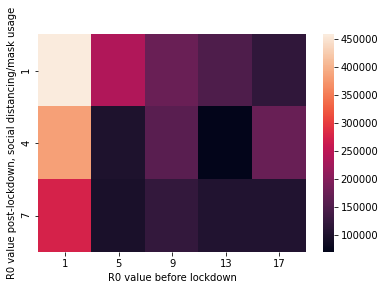

In [0]:
germany_df = pd.read_csv("germany_params.csv", usecols = ['0', '1', '8'], header=0)
germany_df = germany_df[germany_df['8'] == germany_df.groupby(['0', '1'])['8'].transform('min')] 
heatmap1_data = pd.pivot_table(germany_df, values='8', 
                     index=['1'], 
                     columns='0')
b = sb.heatmap(heatmap1_data)
plt.xlabel("R0 value before lockdown")
plt.ylabel("R0 value post-lockdown, social distancing/mask usage")
plt.show()

TypeError: ignored

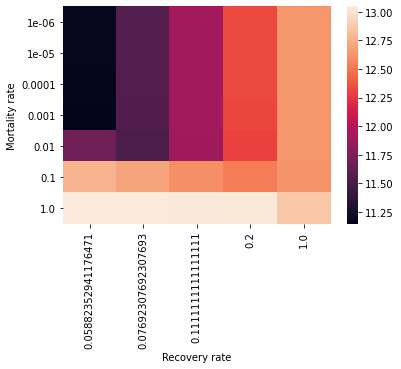

In [0]:
germany_df = pd.read_csv("germany_params.csv", usecols = ['5', '7', '8'], header=0)
germany_df = germany_df[germany_df['8'] == germany_df.groupby(['5', '7'])['8'].transform('min')] 
heatmap1_data = pd.pivot_table(germany_df, values='8', 
                     index=['7'], 
                     columns='5')
heatmap1_data = np.log(heatmap1_data)
sb.heatmap(heatmap1_data)
plt.ylabel("Mortality rate")
plt.xlabel("Recovery rate")
plt.show()

##### Plotting the actual vs predicted data for Germany

In [0]:
N = 83736779
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
germany_df = pd.read_csv("germany_params.csv", header=0)
minIndex = germany_df['8'].idxmin()
a = germany_df.iloc[minIndex]
L1 = a[4]
L2 = a[5]
def parametrize():
    params = minimize(model_loss_lockdown_germany, 
                    x0 = (a[1], a[2], a[3], a[6], a[7], a[8]), 
                    method = 'TNC',
                    bounds = ((3, 50), (1, 20), (0.2, 0.9), (1e-6, 0.5), (1e-6, 0.5), (1e-6, 0.5))).x
    return params
params = parametrize()
ret2 = SEIRD_integrate_lockdown(y0, 55, (params))
S, E, I, R, D = ret2.T
pred_ger2 = get_dataframe(ret2)
pred_ger2.head()
model_loss_lockdown_germany((params))

56942.308254686555

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['active_cases'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=germany_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['I'], name = 'Predicted Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['R'], name='Predicted Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['D'], name='Predicted Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=np.log(germany_actual['active_cases']), name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=np.log(germany_actual['total_recovered']), name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=germany_actual['days'] , y=np.log(germany_actual['total_deaths']), name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=np.log(pred_ger2['I']), name = 'Predicted Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=np.log(pred_ger2['R']), name='Predicted Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=np.log(pred_ger2['D']), name='Predicted Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases(log values)')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



##### Experimental parameter predictions with consolidated literature predictions comparison

In [0]:
N = 83736779
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
germany_df = pd.read_csv("germany_params.csv", header=0)
minIndex = germany_df['8'].idxmin()
a = germany_df.iloc[minIndex]
L1 = a[4]
L2 = a[5]
ret2 = SEIRD_integrate_lockdown(y0, 70, (a[1], a[2], a[3], a[6], a[7], a[8]))
S, E, I, R, D = ret2.T
pred_ger2 = get_dataframe(ret2)
pred_ger2.head()

,days,S,E,I,R,D
0,0,8.373668e+07,10.000000,100.000000,0.000000,0.000000
1,1,8.373661e+07,77.787231,102.961164,5.904074,0.100369
2,2,8.373653e+07,139.834987,118.178110,12.351951,0.209983
3,3,8.373644e+07,205.250540,144.758006,20.029144,0.340495
4,4,8.373632e+07,281.480304,183.439642,29.618728,0.503518


In [0]:
N = 83736779
b0 = 0.212 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.048
d0 = 0.153 # incubation period of ten days
m0 = 0.0013 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_ger = get_dataframe(ret)

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['I'], name = 'Predicted consolidated literature Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['R'], name='Predicted consolidated literature Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=pred_ger['D'], name='Predicted consolidated literature Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['I'], name = 'Predicted experimental parameters Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['R'], name='Predicted experimental parameters Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger2['days'] , y=pred_ger2['D'], name='Predicted experimental parameters Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

### South Korea

#### Loading South Korea data

In [0]:
korea_actual_data = pd.read_excel("ROK_data.xlsx", 
                         parse_dates = ['date'], header = 0,
                         usecols = ['date', 'total_deaths', 'total_infected', 'total recovered'], 
                         index_col = 0)
korea_actual = korea_actual_data[korea_actual_data['total_infected'] > 99]  
korea_actual.insert(0, 'days', list(range(len(korea_actual))), True)
korea_actual = korea_actual.reset_index()
korea_actual.head()

,date,days,total_deaths,total_infected,total recovered
0,2020-02-21,0,2,190,16
1,2020-02-22,1,2,416,16
2,2020-02-23,2,6,578,18
3,2020-02-24,3,8,803,18
4,2020-02-25,4,11,944,22


In [0]:
# ground truth for south korea
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.update_layout(title='South Korea: Actual Data',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases',
                  legend_orientation="h")

#### Literature modelling Korea

Transmission potential and severity of COVID-19 in South Korea

In [0]:
N = 51256387
D = 6.0 # infections lasts 6 days
g0 = 1.0 / D
d0 = 1.0 / 6.0  # incubation period of 6 days
b0 = 1.5 * g0  # R_0 = beta / gamma, so beta = R_0 * gamma
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_kor = get_dataframe(ret)
model_loss_sk((b0, g0, d0, m0))

48572.8337694923

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Use of simulated annealing to determine the operational parameters of the SEIR model for the coronavirus for various jurisdictions

In [0]:
N = 51256387
b0 = 20 * 0.02785969 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.02785969
d0 = 0.4573711  # incubation period of fourteen days
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_kor = get_dataframe(ret)
model_loss_sk((b0, g0, d0, m0))

132765341.09715097

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Predicting the number of reported and unreported cases for the COVID-19 epidemic in South Korea, Italy, France and Germany

In [0]:
N = 51256387
D = 7 # infections lasts fourteen days
b0 = 3.79 * 1.0 / 7.0 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 1.0 / 7.0
d0 = 1.0 / 10.0 # incubation period of ten days
m0 = 0.02 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_kor = get_dataframe(ret)
model_loss_sk((b0, g0, d0, m0))

86407.5175581607

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['I'], name = 'Predicted literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['R'], name='Predicted literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['D'], name='Predicted literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

Consolidated parameter modelling

In [0]:
N = 51256387
b0 = 0.1185 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.079
d0 = 0.120 # incubation period of ten days
m0 = 0.016 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_kor = get_dataframe(ret)
model_loss_sk((b0, g0, d0, m0))

51070.58597269716

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['I'], name = 'Predicted Literature Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['R'], name='Predicted Literature Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['D'], name='Predicted Literature Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

#### Experimenting with parameters over phases

In [0]:
# Total population, N.
N = 51256387
hmap_list = []
for i in range (1, 20, 4):
    for j in range(1, 10, 3):
        for k in range(1, 20, 4):
            for l in range(1, 20, 4):
                for m in range(0, 7):
                    for n in range(10,40,10):
                        h1 = []
                        l1 = i
                        l2 = j
                        l3 = 1
                        L1 = n
                        L2 = n + 10
                        g0 = 1.0 / k
                        d0 = 1.0 / l
                        m0 = 1.0 * 10.0 ** (-m)
                        y0 = N-100, 1, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
                        d = model_loss_lockdown_sk((l1, l2, l3, g0, d0, m0))
                        h1 = [l1, l2, l3, L1, L2, g0, d0, m0, d]
                        hmap_list.append(h1)
                        print(h1)

Streaming output truncated to the last 5000 lines.
[5, 7, 1, 30, 40, 0.1111111111111111, 0.2, 1e-06, 1988563.7799005955]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 1.0, 52767.22055622646]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 1.0, 52765.990502572175]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 1.0, 52765.76017799087]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.1, 46421.618036559725]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 0.1, 41973.66827379791]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 0.1, 42015.229750734245]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.01, 29856.414977158995]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 0.01, 56745.51603729473]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 0.01, 185348.86635978884]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 0.001, 28175.004057848742]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.11111111

In [0]:
korea_df = pd.DataFrame(hmap_list)
korea_df.to_csv('korea_params.csv')

##### Plotting heatmap for South Korea data

TypeError: ignored

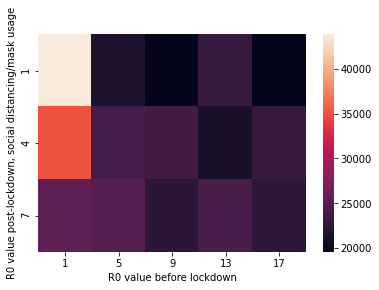

In [0]:
korea_df = pd.read_csv("korea_params.csv", usecols = ['0', '1', '8'], header=0)
korea_df = korea_df[korea_df['8'] == korea_df.groupby(['0', '1'])['8'].transform('min')] 
heatmap1_data = pd.pivot_table(korea_df, values='8', 
                     index=['1'], 
                     columns='0')
b = sb.heatmap(heatmap1_data)
plt.xlabel("R0 value before lockdown")
plt.ylabel("R0 value post-lockdown, social distancing/mask usage")
plt.show()

TypeError: ignored

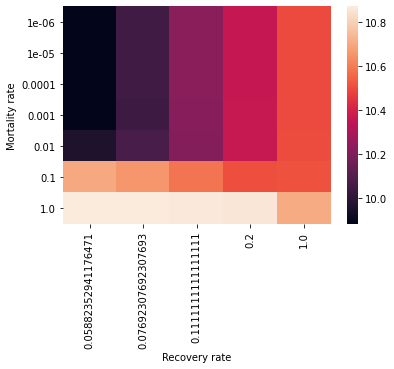

In [0]:
korea_df = pd.read_csv("korea_params.csv", usecols = ['5', '7', '8'], header=0)
korea_df = korea_df[korea_df['8'] == korea_df.groupby(['5', '7'])['8'].transform('min')] 
heatmap1_data = pd.pivot_table(korea_df, values='8', 
                     index=['7'], 
                     columns='5')
heatmap1_data = np.log(heatmap1_data)
sb.heatmap(heatmap1_data)
plt.ylabel("Mortality rate")
plt.xlabel("Recovery rate")
plt.show()

##### Plotting the actual vs predicted data for South Korea

In [0]:
N = 51256387
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
korea_df = pd.read_csv("korea_params.csv", header=0)
minIndex = korea_df['8'].idxmin()
a = korea_df.iloc[minIndex]
L1 = a[4]
L2 = a[5]
def parametrize():
    params = minimize(model_loss_lockdown_sk, 
                    x0 = (a[1], a[2], a[3], a[6], a[7], a[8]), 
                    method = 'TNC',
                    bounds = ((3, 50), (1, 20), (0.2, 0.9), (1e-6, 0.5), (1e-6, 0.5), (1e-6, 0.5))).x
    return params
params = parametrize()
ret2 = SEIRD_integrate_lockdown(y0, 63, (params))
S, E, I, R, D = ret2.T
pred_kor2 = get_dataframe(ret2)
pred_kor2.head()
model_loss_lockdown_sk((params))

19197.892864675756

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_infected'], name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total recovered'], name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=korea_actual['total_deaths'], name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['I'], name = 'Predicted Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['R'], name='Predicted Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['D'], name='Predicted Fatalities',line=dict(color='red', width=4, dash='dot')))
fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')


In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=np.log(korea_actual['total_infected']), name = 'Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=np.log(korea_actual['total recovered']), name='Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=korea_actual['days'] , y=np.log(korea_actual['total_deaths']), name='Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=np.log(pred_kor2['I']), name = 'Predicted Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=np.log(pred_kor2['R']), name='Predicted Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=np.log(pred_kor2['D']), name='Predicted Fatalities',line=dict(color='red', width=4, dash='dot')))
fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases(log values)')


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



##### Experimental parameter predictions with consolidated literature predictions comparison

In [0]:
N = 51256387
b0 = 0.1185 # R_0 = beta / gamma, so beta = R_0 * gamma
g0 = 0.079
d0 = 0.120 # incubation period of ten days
m0 = 0.016 #case fatality rate
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
# Integrate the SIR equations over the time grid, t.
ret = SEIRD_integrate(y0, 70, (b0, g0, d0, m0))
S, E, I, R, D = ret.T
pred_kor = get_dataframe(ret)

In [0]:
N = 51256387
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
korea_df = pd.read_csv("korea_params.csv", header=0)
minIndex = korea_df['8'].idxmin()
a = korea_df.iloc[minIndex]
L1 = a[4]
L2 = a[5]
ret2 = SEIRD_integrate_lockdown(y0, 70, (a[1], a[2], a[3], a[6], a[7], a[8]))
S, E, I, R, D = ret2.T
pred_kor2 = get_dataframe(ret2)
pred_kor2.head()

,days,S,E,I,R,D
0,0,5.125629e+07,10.000000,100.000000,0.000000,0.000000
1,1,5.125619e+07,99.907245,105.153659,5.947644,0.101110
2,2,5.125608e+07,186.046792,126.814922,12.692396,0.215771
3,3,5.125595e+07,283.769230,164.850016,21.186332,0.360168
4,4,5.125577e+07,406.860772,221.909805,32.457890,0.551784


In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['I'], name = 'Predicted consolidated literature Infected',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['R'], name='Predicted consolidated literature Recovered',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=pred_kor['D'], name='Predicted consolidated literature Fatalities',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['I'], name = 'Predicted experimental parameters Infected',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['R'], name='Predicted experimental parameters Recovered',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_kor2['days'] , y=pred_kor2['D'], name='Predicted experimental parameters Fatalities',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases')

### Predicted Germany vs South Korea

In [0]:
N = 83736779
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
germany_df = pd.read_csv("germany_params.csv", header=0)
minIndex = germany_df['8'].idxmin()
a = germany_df.iloc[minIndex]
print(a)
L1 = a[4]
L2 = a[5]
ret2 = SEIRD_integrate_lockdown(y0, 70, (a[1], a[2], a[3], a[6], a[7], a[8]))
S, E, I, R, D = ret2.T
pred_ger = get_dataframe(ret2)
pred_ger.head()

Unnamed: 0     5701.000000
0                13.000000
1                 4.000000
2                 1.000000
3                20.000000
4                30.000000
5                 0.058824
6                 0.200000
7                 0.001000
8             69131.056705
Name: 5701, dtype: float64


,days,S,E,I,R,D
0,0,8.373668e+07,10.000000,100.000000,0.000000,0.000000
1,1,8.373661e+07,77.787231,102.961164,5.904074,0.100369
2,2,8.373653e+07,139.834987,118.178110,12.351951,0.209983
3,3,8.373644e+07,205.250540,144.758006,20.029144,0.340495
4,4,8.373632e+07,281.480304,183.439642,29.618728,0.503518


In [0]:
N = 51256387
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
korea_df = pd.read_csv("korea_params.csv", header=0)
minIndex = korea_df['8'].idxmin()
a = korea_df.iloc[minIndex]
print(a)
L1 = a[4]
L2 = a[5]
ret2 = SEIRD_integrate_lockdown(y0, 70, (a[1], a[2], a[3], a[6], a[7], a[8]))
S, E, I, R, D = ret2.T
pred_kor = get_dataframe(ret2)
pred_kor.head()

Unnamed: 0     6750.000000
0                17.000000
1                 1.000000
2                 1.000000
3                10.000000
4                20.000000
5                 0.058824
6                 0.200000
7                 0.001000
8             19598.618275
Name: 6750, dtype: float64


,days,S,E,I,R,D
0,0,5.125629e+07,10.000000,100.000000,0.000000,0.000000
1,1,5.125619e+07,99.907245,105.153659,5.947644,0.101110
2,2,5.125608e+07,186.046792,126.814922,12.692396,0.215771
3,3,5.125595e+07,283.769230,164.850016,21.186332,0.360168
4,4,5.125577e+07,406.860772,221.909805,32.457890,0.551784


In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=np.log(pred_kor['I']), name = 'Predicted Infected South Korea',line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=np.log(pred_kor['R']), name='Predicted Recovered South Korea',line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=pred_kor['days'] , y=np.log(pred_kor['D']), name='Predicted Fatalities South Korea',line=dict(color='red', width=4)))

fig.add_trace(go.Scatter(x=pred_ger['days'] , y=np.log(pred_ger['I']), name = 'Predicted Infected Germany',line=dict(color='blue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=np.log(pred_ger['R']), name='Predicted Recovered Germany',line=dict(color='green', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=pred_ger['days'] , y=np.log(pred_ger['D']), name='Predicted Fatalities Germany',line=dict(color='red', width=4, dash='dot')))


fig.update_layout(title='Germany vs South Korea Cases Plot',
                   xaxis_title='Days since 100th case',
                   yaxis_title='Number of cases(log values)')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

